In [39]:

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns

from xgboost import XGBRegressor 
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
#from fbprophet import Prophet
#from fbprophet.plot import plot_plotly, add_changepoints_to_plot
# from keras.models import Sequential
# from keras.layers import Dense

# from keras.optimizers import Adam
warnings.filterwarnings('ignore')

In [40]:
data=pd.read_csv('univariate_models/multivar.csv', index_col=0, parse_dates=[0])
print(data.shape)
data = data.drop(columns=['iso_code'])
data = data.set_index('date')
main = ['continent', 'tests_units', 'season', 'location']
data = pd.get_dummies(data, columns=main)

# Sort the DataFrame by the 'date' column
data = data.sort_index()
train_size = int(len(data) * 0.8)
train=data.iloc[:train_size ] 
test=data.iloc[train_size: ] 
print(train.shape, test.shape)

(2023, 53)
(1618, 67) (405, 67)


In [41]:

x_train = train.drop(columns=['new_deaths']) 
x_test = test.drop(columns=['new_deaths']) 
y_train = train['new_deaths']
y_test = test['new_deaths']

In [42]:
metrics_df = pd.DataFrame(columns=['Model','mae','mase'])
metrics_df

,Model,mae,mase


In [43]:
data.dtypes

total_cases                float64
new_cases                  float64
new_deaths                 float64
total_cases_per_million    float64
new_cases_per_million      float64
                            ...   
location_Ireland              bool
location_Israel               bool
location_Italy                bool
location_Malaysia             bool
location_United States        bool
Length: 67, dtype: object

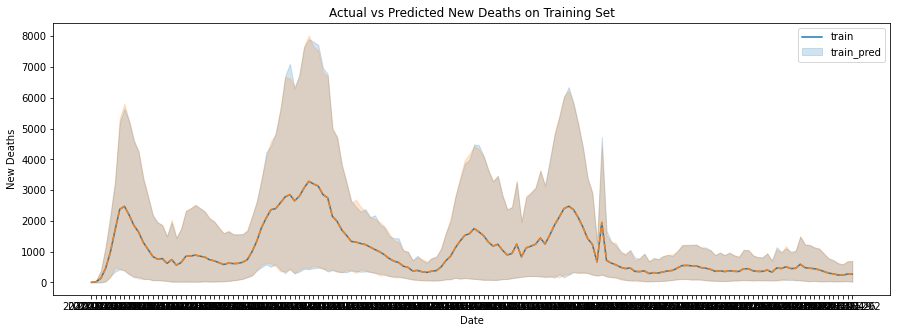

In [44]:
# Create XGBoost model
model = xgb.XGBRegressor()

model.fit(x_train, y_train)

# Predict on the training set
train_pred = pd.DataFrame(model.predict(x_train), columns=['yhat'], index=train.index)

# Plot the actual vs predicted values
plt.figure(figsize=(15, 5))
sns.lineplot(data=pd.concat([train['new_deaths'], train_pred['yhat']], axis=1))
plt.legend(['train', 'train_pred'])
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.title('Actual vs Predicted New Deaths on Training Set')
plt.show()

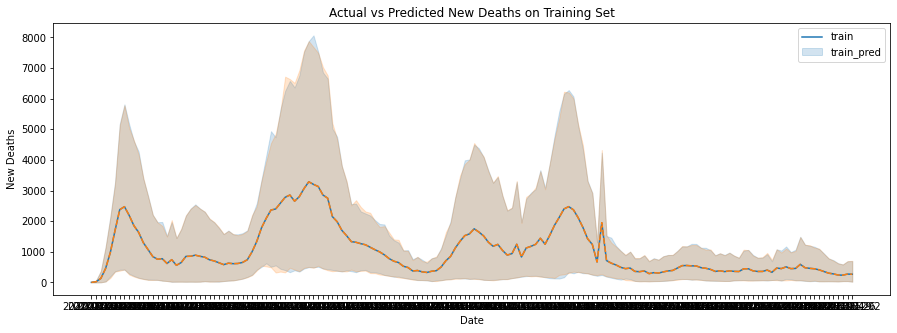

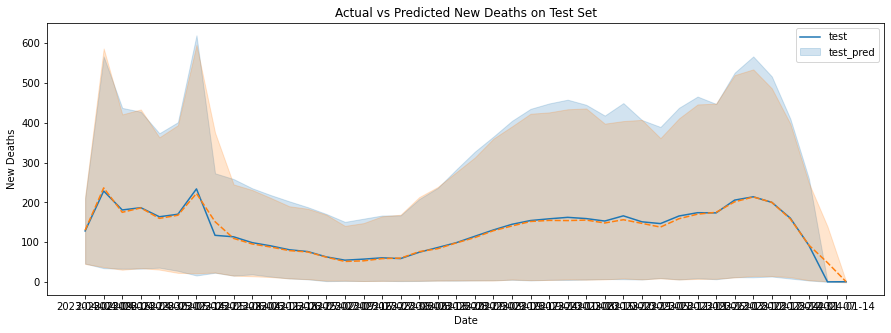

In [45]:
train_pred = pd.DataFrame(model.predict(x_train), columns=['yhat'], index=train.index)

# Plot the actual vs predicted values for training set
plt.figure(figsize=(15, 5))
sns.lineplot(data=pd.concat([train['new_deaths'], train_pred['yhat']], axis=1))
plt.legend(['train', 'train_pred'])
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.title('Actual vs Predicted New Deaths on Training Set')
plt.show()

# Predict on the test set
test_pred = pd.DataFrame(model.predict(x_test), columns=['yhat'], index=test.index)

# Plot the actual vs predicted values for test set
plt.figure(figsize=(15, 5))
sns.lineplot(data=pd.concat([test['new_deaths'], test_pred['yhat']], axis=1))
plt.legend(['test', 'test_pred'])
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.title('Actual vs Predicted New Deaths on Test Set')
plt.show()

In [46]:
def mean_absolute_scaled_error(y_true, y_pred):
    naive_forecast = np.array(y_true[:-1])
    y_true_insample = np.array(y_true[1:])
    insample_error = np.abs(y_true_insample - naive_forecast)
    # Calculate the forecast errors
    forecast_error = np.abs(y_true - y_pred)
    # Calculate the MASE
    mase = np.mean(forecast_error) / np.mean(insample_error)
    return mase

In [47]:
actuals = test['new_deaths'] 
predictions = test_pred['yhat'] 
mase = mean_absolute_scaled_error(actuals, predictions) 
mae = mean_absolute_error(actuals, predictions)

metrics_df.loc[len(metrics_df)] = ['base xgb',mae, mase]

In [48]:
metrics_df

,Model,mae,mase
0,base xgb,7.759172,0.032464


In [49]:
import optuna
import sklearn.datasets
import sklearn.metrics

In [50]:


def objective(trial):

    param = {
        'objective': 'reg:squarederror',  # Assuming it's a regression task
        'eval_metric': 'mae',  # Using Mean Absolute Error as the evaluation metric
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.1, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
   
    }

    bst = xgb.train(param, xgb.DMatrix(train.drop('new_deaths', axis=1), label=train['new_deaths']))
    preds = bst.predict(xgb.DMatrix(train.drop('new_deaths', axis=1)))
    
    accuracy = sklearn.metrics.mean_absolute_error(train['new_deaths'], preds)
    return accuracy

study = optuna.create_study(direction='minimize')  # Use 'minimize' for Mean Absolute  Error
study.optimize(objective, n_trials=10)

# Access the best parameters
best_params = study.best_params
print("Best Params:", best_params)


[I 2024-03-11 12:43:47,975] A new study created in memory with name: no-name-aa5be5ab-4d85-443e-85fa-45fec147e6ff
[I 2024-03-11 12:43:48,203] Trial 0 finished with value: 26.723202357775495 and parameters: {'n_estimators': 65, 'learning_rate': 0.3296137420147675, 'max_depth': 9}. Best is trial 0 with value: 26.723202357775495.


[12:43:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:43:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2024-03-11 12:43:48,292] Trial 1 finished with value: 172.96894679479163 and parameters: {'n_estimators': 287, 'learning_rate': 0.1711154432397924, 'max_depth': 7}. Best is trial 0 with value: 26.723202357775495.
[I 2024-03-11 12:43:48,360] Trial 2 finished with value: 70.15543156589655 and parameters: {'n_estimators': 222, 'learning_rate': 0.3576280337182386, 'max_depth': 3}. Best is trial 0 with value: 26.723202357775495.
[I 2024-03-11 12:43:48,496] Trial 3 finished with value: 11.599865765742525 and parameters: {'n_estimators': 199, 'learning_rate': 0.4938199254400218, 'max_depth': 7}. Best is trial 3 with value: 11.599865765742525.


[12:43:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:43:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2024-03-11 12:43:48,633] Trial 4 finished with value: 22.479180496814575 and parameters: {'n_estimators': 242, 'learning_rate': 0.34571353856025655, 'max_depth': 10}. Best is trial 3 with value: 11.599865765742525.


[12:43:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:43:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2024-03-11 12:43:48,734] Trial 5 finished with value: 16.722719789417035 and parameters: {'n_estimators': 50, 'learning_rate': 0.3715059895827303, 'max_depth': 10}. Best is trial 3 with value: 11.599865765742525.
[I 2024-03-11 12:43:48,849] Trial 6 finished with value: 227.31554011464561 and parameters: {'n_estimators': 85, 'learning_rate': 0.1467720704562625, 'max_depth': 7}. Best is trial 3 with value: 11.599865765742525.
[I 2024-03-11 12:43:48,934] Trial 7 finished with value: 314.486556866555 and parameters: {'n_estimators': 115, 'learning_rate': 0.1175573053336664, 'max_depth': 5}. Best is trial 3 with value: 11.599865765742525.


[12:43:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:43:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2024-03-11 12:43:48,993] Trial 8 finished with value: 75.50070104610788 and parameters: {'n_estimators': 183, 'learning_rate': 0.38917591975024585, 'max_depth': 3}. Best is trial 3 with value: 11.599865765742525.
[I 2024-03-11 12:43:49,097] Trial 9 finished with value: 256.9818723422783 and parameters: {'n_estimators': 90, 'learning_rate': 0.13566787941655742, 'max_depth': 6}. Best is trial 3 with value: 11.599865765742525.


[12:43:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:43:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

Best Params: {'n_estimators': 199, 'learning_rate': 0.4938199254400218, 'max_depth': 7}


In [51]:
model = xgb.XGBRegressor(n_estimators = 65, learning_rate = 0.3210929352407252, max_depth = 10)
model.fit(train.drop('new_deaths', axis=1), train['new_deaths']);

In [70]:
train_pred=pd.DataFrame(model.predict(train.drop('new_deaths', axis=1)), columns=['yhat'], index=train.index)
train_pred.head()
pd.concat([train['new_deaths'],train_pred['yhat']], axis=1).(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])

AttributeError: 'DataFrame' object has no attribute 'lineplot'

<Figure size 1080x720 with 0 Axes>

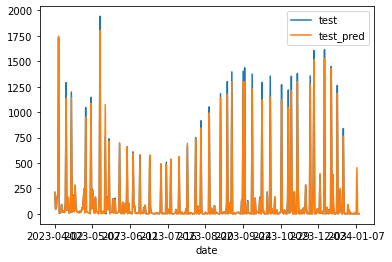

In [53]:
test_pred=pd.DataFrame(model.predict(test.drop('new_deaths', axis=1)), columns=['yhat'], index=test.index)
plt.figure(figsize=(15, 10))
pd.concat([test['new_deaths'],test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])

In [54]:
test_pred

,yhat
date,
2023-04-02,212.238846
2023-04-02,45.536182
2023-04-09,52.380371
2023-04-09,169.841690
2023-04-09,201.076065
...,...
2024-01-07,-0.335079
2024-01-07,453.576691
2024-01-14,-0.042091


In [55]:
actuals = test['new_deaths'] 
predictions = test_pred['yhat'] 
mase = mean_absolute_scaled_error(actuals, predictions) 
mae = mean_absolute_error(actuals, predictions)

metrics_df.loc[len(metrics_df)] = ['optuna xgb',mae, mase]

In [56]:
metrics_df

,Model,mae,mase
0,base xgb,7.759172,0.032464
1,optuna xgb,10.435996,0.043664


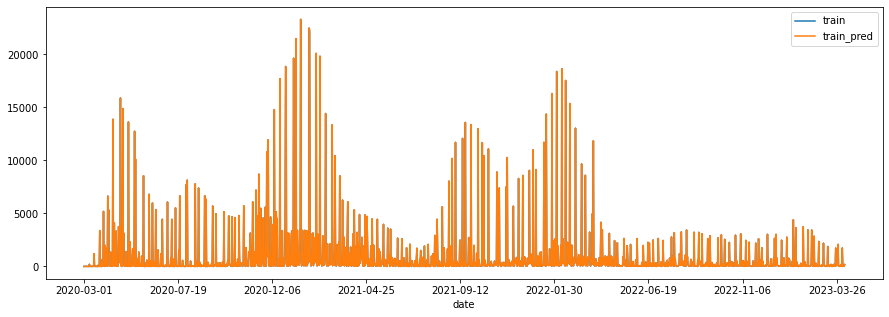

<Figure size 1080x720 with 0 Axes>

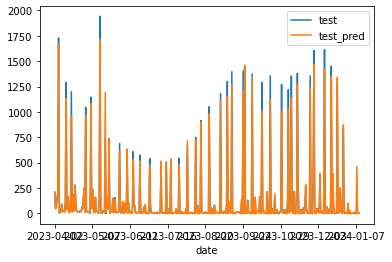

In [57]:
model = xgb.XGBRegressor(n_estimators = 191, learning_rate = 0.44398439655293526, max_depth = 8)
model.fit(train.drop('new_deaths', axis=1), train['new_deaths']);

train_pred=pd.DataFrame(model.predict(train.drop('new_deaths', axis=1)), columns=['yhat'], index=train.index)
train_pred.head()
pd.concat([train['new_deaths'],train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
test_pred=pd.DataFrame(model.predict(test.drop('new_deaths', axis=1)), columns=['yhat'], index=test.index)
plt.figure(figsize=(15, 10))
pd.concat([test['new_deaths'],test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])

In [58]:
actuals = test['new_deaths'] 
predictions = test_pred['yhat'] 
mase = mean_absolute_scaled_error(actuals, predictions) 
mae = mean_absolute_error(actuals, predictions)

metrics_df.loc[len(metrics_df)] = ['optuna 2xgb',mae, mase]

In [59]:
metrics_df

,Model,mae,mase
0,base xgb,7.759172,0.032464
1,optuna xgb,10.435996,0.043664
2,optuna 2xgb,14.239211,0.059576


In [60]:
import optuna 

# Define the objective function for Optuna
def objective(trial):
    param = {
        'objective': 'reg:squarederror',  # Assuming it's a regression task
        'eval_metric': 'mae',  # Using Mean Absolute Error as the evaluation metric
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.1, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
    }

    # Train the XGBoost model
    bst = xgb.train(param, xgb.DMatrix(train.drop('new_deaths', axis=1), label=train['new_deaths']))
    
    # Predict on the test set
    preds = bst.predict(xgb.DMatrix(test.drop('new_deaths', axis=1)))
    pred_labels = np.rint(preds)
    
    # Calculate Mean Absolute Error
    accuracy = sklearn.metrics.mean_absolute_error(test['new_deaths'], pred_labels)
    
    return accuracy


study = optuna.create_study(direction='minimize')  # Use 'minimize' for Mean Absolute Percentage Error
study.optimize(objective, n_trials=10)

# Access the best parameters
best_params = study.best_params
print("Best Params:", best_params)




[I 2024-03-11 12:44:04,336] A new study created in memory with name: no-name-03277289-463a-4bfb-aae9-e7b817bc451d
[I 2024-03-11 12:44:05,204] Trial 0 finished with value: 10.839506172839506 and parameters: {'learning_rate': 0.2914068085758827, 'max_depth': 9}. Best is trial 0 with value: 10.839506172839506.
[I 2024-03-11 12:44:05,581] Trial 1 finished with value: 10.65679012345679 and parameters: {'learning_rate': 0.35488579801072456, 'max_depth': 10}. Best is trial 1 with value: 10.65679012345679.
[I 2024-03-11 12:44:05,719] Trial 2 finished with value: 17.965432098765433 and parameters: {'learning_rate': 0.4692062126279799, 'max_depth': 5}. Best is trial 1 with value: 10.65679012345679.
[I 2024-03-11 12:44:05,920] Trial 3 finished with value: 14.449382716049383 and parameters: {'learning_rate': 0.28086211679913237, 'max_depth': 6}. Best is trial 1 with value: 10.65679012345679.
[I 2024-03-11 12:44:06,258] Trial 4 finished with value: 13.212345679012346 and parameters: {'learning_rate

Best Params: {'learning_rate': 0.35488579801072456, 'max_depth': 10}


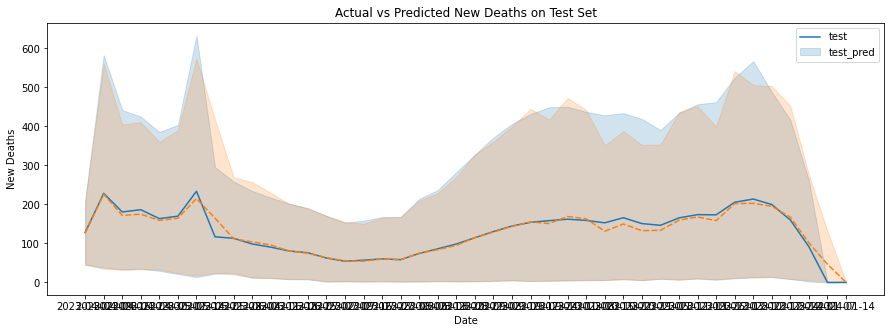

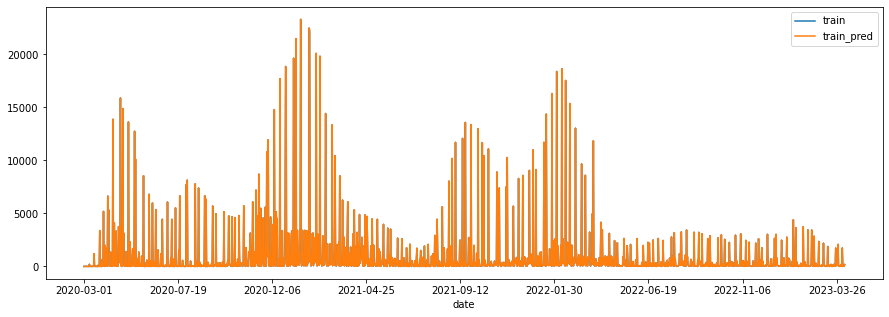

<Figure size 1080x720 with 0 Axes>

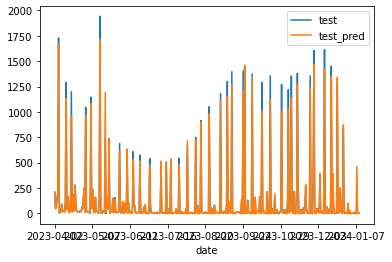

In [64]:
# Train the final XGBoost model with the best parameters
final_model = xgb.XGBRegressor(**best_params)
final_model.fit(train.drop('new_deaths', axis=1), train['new_deaths'])

# Predict on the test set using the final model
test_preds = final_model.predict(test.drop('new_deaths', axis=1))
test_pred_labels = np.rint(test_preds)

# Plot the actual vs predicted values for the test set
plt.figure(figsize=(15, 5))
sns.lineplot(data=pd.concat([test['new_deaths'], pd.Series(test_pred_labels, index=test.index)], axis=1))
plt.legend(['test', 'test_pred'])
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.title('Actual vs Predicted New Deaths on Test Set')
plt.show()
train_pred=pd.DataFrame(model.predict(train.drop('new_deaths', axis=1)), columns=['yhat'], index=train.index)
train_pred.head()
pd.concat([train['new_deaths'],train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
test_pred=pd.DataFrame(model.predict(test.drop('new_deaths', axis=1)), columns=['yhat'], index=test.index)
plt.figure(figsize=(15, 10))
pd.concat([test['new_deaths'],test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])

In [65]:
actuals = test['new_deaths'] 
predictions = test_pred['yhat'] 
mase = mean_absolute_scaled_error(actuals, predictions) 
mae = mean_absolute_error(actuals, predictions)

metrics_df.loc[len(metrics_df)] = ['optuna xgb 3',mae, mase]

In [66]:
metrics_df

,Model,mae,mase
0,base xgb,7.759172,0.032464
1,optuna xgb,10.435996,0.043664
2,optuna 2xgb,14.239211,0.059576
3,optuna xgb 3,14.239211,0.059576
4,optuna xgb 3,14.239211,0.059576


[I 2024-03-11 13:25:36,933] A new study created in memory with name: no-name-523d87a8-a98d-4462-b8bd-04bbcf1374fc


[I 2024-03-11 13:25:37,042] Trial 0 finished with value: 15.306172839506173 and parameters: {'max_depth': 5, 'min_child_weight': 4}. Best is trial 0 with value: 15.306172839506173.
[I 2024-03-11 13:25:37,122] Trial 1 finished with value: 24.350617283950616 and parameters: {'max_depth': 4, 'min_child_weight': 6}. Best is trial 0 with value: 15.306172839506173.
[I 2024-03-11 13:25:37,215] Trial 2 finished with value: 11.846913580246914 and parameters: {'max_depth': 6, 'min_child_weight': 5}. Best is trial 2 with value: 11.846913580246914.
[I 2024-03-11 13:25:37,318] Trial 3 finished with value: 9.671604938271605 and parameters: {'max_depth': 6, 'min_child_weight': 4}. Best is trial 3 with value: 9.671604938271605.
[I 2024-03-11 13:25:37,413] Trial 4 finished with value: 13.797530864197531 and parameters: {'max_depth': 5, 'min_child_weight': 6}. Best is trial 3 with value: 9.671604938271605.
[I 2024-03-11 13:25:37,479] Trial 5 finished with value: 11.846913580246914 and parameters: {'max_

Best Params: {'max_depth': 6, 'min_child_weight': 4}


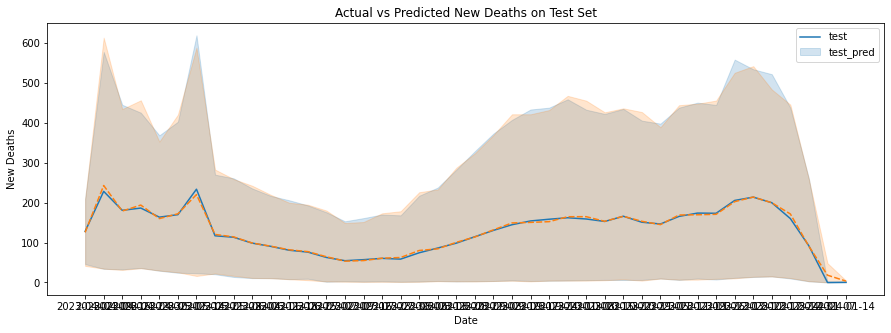

,Model,mae,mase
0,base xgb,7.759172,0.032464
1,optuna xgb,10.435996,0.043664
2,optuna 2xgb,14.239211,0.059576
3,optuna xgb 3,14.239211,0.059576
4,optuna xgb 3,14.239211,0.059576
5,optuna xgb 3,14.239211,0.059576
6,optuna xgb 3,14.239211,0.059576


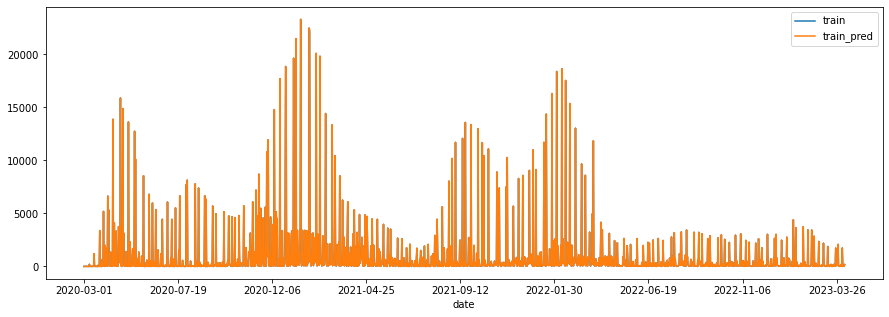

<Figure size 1080x720 with 0 Axes>

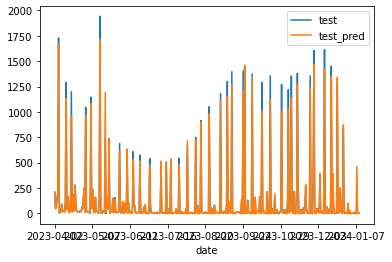

In [69]:

# Define the objective function for Optuna
def objective(trial):
    param = {
        'objective': 'reg:squarederror',  # Assuming it's a regression task
        'eval_metric': 'mae',  # Using Mean Absolute Error as the evaluation metric
        'max_depth':trial.suggest_int('max_depth',4,6),
        'min_child_weight':trial.suggest_int('min_child_weight',4,6)
    }

    # Train the XGBoost model
    bst = xgb.train(param, xgb.DMatrix(train.drop('new_deaths', axis=1), label=train['new_deaths']))
    
    # Predict on the test set
    preds = bst.predict(xgb.DMatrix(test.drop('new_deaths', axis=1)))
    pred_labels = np.rint(preds)
    
    # Calculate Mean Absolute Error
    accuracy = sklearn.metrics.mean_absolute_error(test['new_deaths'], pred_labels)
    
    return accuracy


study = optuna.create_study(direction='minimize')  # Use 'minimize' for Mean Absolute Percentage Error
study.optimize(objective, n_trials=10)

# Access the best parameters
best_params = study.best_params
print("Best Params:", best_params)



# Train the final XGBoost model with the best parameters
final_model = xgb.XGBRegressor(**best_params)
final_model.fit(train.drop('new_deaths', axis=1), train['new_deaths'])

# Predict on the test set using the final model
test_preds = final_model.predict(test.drop('new_deaths', axis=1))

# Plot the actual vs predicted values for the test set
plt.figure(figsize=(15, 5))
sns.lineplot(data=pd.concat([test['new_deaths'], pd.Series(test_preds, index=test.index)], axis=1))
plt.legend(['test', 'test_pred'])
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.title('Actual vs Predicted New Deaths on Test Set')
plt.show()
train_pred=pd.DataFrame(model.predict(train.drop('new_deaths', axis=1)), columns=['yhat'], index=train.index)
train_pred.head()
pd.concat([train['new_deaths'],train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
test_pred=pd.DataFrame(model.predict(test.drop('new_deaths', axis=1)), columns=['yhat'], index=test.index)
plt.figure(figsize=(15, 10))
pd.concat([test['new_deaths'],test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
actuals = test['new_deaths'] 
predictions = test_pred['yhat'] 
mase = mean_absolute_scaled_error(actuals, predictions) 
mae = mean_absolute_error(actuals, predictions)

metrics_df.loc[len(metrics_df)] = ['optuna xgb 3',mae, mase]
metrics_df